In [20]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import xarray as xr

import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from delhi_aq.jax.my_nn import SIREN, fit, NeRF, NeRFPE
from delhi_aq.jax.my_utils import pool_image, get_coords_for_image, rmse_fn

import matplotlib.pyplot as plt
from multiprocessing import Pool

In [21]:
seed = 1
aq_data = xr.open_dataset("../processed_data/delhi_cpcb_2022_cleaned.nc").to_dataframe().reset_index().set_index("time")
print(aq_data.columns)
all_stations = aq_data.dropna(subset="PM2.5").station.unique()

Index(['station', 'From Date', 'To Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
       'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'RH', 'WS', 'WD',
       'SR', 'BP', 'AT', 'RF', 'TOT-RF', 'latitude', 'longitude'],
      dtype='object')


In [22]:
aq_data.shape[0]/39

8783.0

In [23]:
result_df = aq_data.drop_duplicates(subset=["station"]).set_index("station")[["latitude", "longitude"]]
def load_and_process_data(station):
    # print("###############")
    # print(f"Station: {station}")
    # print("###############")
    timeseries = aq_data[aq_data["station"] == station][['From Date', 'PM2.5']]
    init_len = timeseries.shape[0]
    timeseries['x'] = np.linspace(-1, 1, init_len)
    timeseries.dropna(subset=["PM2.5"], inplace=True)
    final_len = timeseries.shape[0]
    missing_data_frac = 1 - final_len/init_len
    # print(f"Initial length={init_len}, Final length={final_len}, missing data frac={missing_data_frac:.2f}")
    
    x = timeseries['x'].values.reshape(-1, 1)
    y = timeseries['PM2.5'].values.reshape(-1, 1)
    train_offset = int(0.9 * x.shape[0])
    val_offset = int(0.99 * x.shape[0])
    train_x_, train_y_ = x[:train_offset], y[:train_offset]
    val_x_, val_y_ = x[train_offset:val_offset], y[train_offset:val_offset]
    test_x_, test_y_ = x[val_offset:], y[val_offset:]
    print(train_x_.shape, val_x_.shape, test_x_.shape, train_y_.shape, val_y_.shape, test_y_.shape)
    # train_val_x_, test_x_, train_val_y_, test_y_ = train_test_split(x, y, test_size=0.2, random_state=seed+1)
    # train_x_, val_x_, train_y_, val_y_ = train_test_split(train_val_x_, train_val_y_, test_size=0.2, random_state=seed+2)
    return train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac
    
def run(station, gpu_id):
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
    x_scaler = MinMaxScaler((-1, 1))
    y_scaler = MinMaxScaler((-1, 1))
    train_x = x_scaler.fit_transform(train_x_)
    val_x = x_scaler.transform(val_x_)
    test_x = x_scaler.transform(test_x_)
    train_y = y_scaler.fit_transform(train_y_)
    val_y = y_scaler.transform(val_y_)
    test_y = y_scaler.transform(test_y_)
    # print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)
    
    model = SIREN(n_hidden_layer_neurons=[256, 256, 256, 256], output_shape=train_y_.shape[-1], activation_scale=30.0)
    config = {"lr":1e-4, "batch_size":-1, "iterations": 10000}
    params, old_params_history, train_losses, val_losses, test_losses = fit(jax.random.PRNGKey(seed+3), model, 
                                                                            train_x, train_y, config, val_x, val_y, test_x, test_y)
    
    # plt.plot(train_losses, label="train")
    # plt.plot(val_losses, label="val")
    # plt.plot(test_losses, label="test")
    # plt.legend();
    
    best_val_idx = jnp.argmin(val_losses)
    best_params = jtu.tree_map(lambda x: x[best_val_idx], old_params_history)

    pred_y = model.apply(best_params, test_x).__array__()
    pred_y_ = y_scaler.inverse_transform(pred_y)
    # plt.scatter(test_y_, pred_y_)
    # plt.plot([0, 500], [0, 500], color="r", linestyle="--");

    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, missing_data_frac

# run the above function parallely on 4 GPUs using multiprocessing
# I want to dynamically allocate GPUs as they become available

pool = Pool(4)
results = []
for station in tqdm(all_stations):
    gpu_id = len(results) % 4
    results.append(pool.apply_async(run, args=(station, gpu_id)))
pool.close()
pool.join()

result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
result_df.to_csv("results/temporal_interpolation_SIREN.csv")

100%|██████████| 39/39 [00:00<00:00, 90175.22it/s]

(7713, 1)(7326, 1)(7555, 1)(7670, 1)   (733, 1) (756, 1) (772, 1)(767, 1) (82, 1)  (84, 1) (86, 1)(86, 1)(7326, 1)    (7555, 1)(7713, 1)(7670, 1) (733, 1) (756, 1)  (767, 1) (82, 1)(772, 1)(84, 1) 

 (86, 1)(86, 1)



(7793, 1) (779, 1) (87, 1) (7793, 1) (779, 1) (87, 1)
(4957, 1) (495, 1) (56, 1) (4957, 1) (495, 1) (56, 1)
(7696, 1) (770, 1) (86, 1) (7696, 1) (770, 1) (86, 1)
(4082, 1) (408, 1) (46, 1) (4082, 1) (408, 1) (46, 1)
(6450, 1) (645, 1) (72, 1) (6450, 1) (645, 1) (72, 1)
(7794, 1) (780, 1) (87, 1) (7794, 1) (780, 1) (87, 1)
(7745, 1) (774, 1) (87, 1) (7745, 1) (774, 1) (87, 1)
(7742, 1) (774, 1) (87, 1) (7742, 1) (774, 1) (87, 1)
(7017, 1) (702, 1) (78, 1) (7017, 1) (702, 1) (78, 1)
(7629, 1) (763, 1) (85, 1) (7629, 1) (763, 1) (85, 1)
(7657, 1) (765, 1) (86, 1) (7657, 1) (765, 1) (86, 1)
(7499, 1) (750, 1) (84, 1) (7499, 1) (750, 1) (84, 1)
(3728, 1) (373, 1) (42, 1) (3728, 1) (373, 1) (42, 1)
(7668, 1) (766, 1) (86, 1) (7668, 1) (766, 1) (86, 1)
(7729, 1) (773, 1) (86, 1) (7729, 1) (773, 1) (86, 1)
(7509, 1) (751, 1) (84, 1) (7509, 1) (751, 1) (84, 1)
(7712, 1) (771, 1) (86, 1) (7712, 1) (771, 1) (86, 1)
(7512, 1) (751, 1) (84, 1) (7512, 1) (84, 1)(751, 1) 
(7311, 1) (731, 1) (82, 1) (

## RF

In [24]:
def run(station):
    train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
    # train_val_x_ = np.concatenate([train_x_, val_x_], axis=0)
    # train_val_y_ = np.concatenate([train_y_, val_y_], axis=0)
    
    model = RandomForestRegressor(n_estimators=1000, random_state=seed)
    model.fit(train_x_, train_y_.ravel())
    pred_y_ = model.predict(test_x_)
    
    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, missing_data_frac

pool = Pool(32)
results = []
for station in tqdm(all_stations):
    results.append(pool.apply_async(run, args=(station,)))
pool.close()
pool.join()

result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
result_df.to_csv("results/temporal_interpolation_RF.csv")

100%|██████████| 39/39 [00:00<00:00, 102556.65it/s]

(7670, 1) (767, 1) (86, 1) (7670, 1)(4082, 1)(7311, 1)(7712, 1)(7629, 1)(7794, 1)(7326, 1)(7696, 1)(7657, 1) (7713, 1)(7499, 1)(6450, 1)(7793, 1)(4957, 1)(7555, 1) (3728, 1)  (7668, 1) (767, 1)   (7745, 1)    (731, 1)  (771, 1)  (408, 1)(733, 1) (7729, 1)(7512, 1) (770, 1)(763, 1)(780, 1)(645, 1)(750, 1)(7509, 1)(756, 1) (765, 1)(772, 1)(7661, 1)(7642, 1) (373, 1)(495, 1) (779, 1)  (766, 1)(7635, 1)(86, 1)     (7652, 1)    (774, 1)    (82, 1)  (86, 1)(82, 1)  (46, 1)
 (86, 1)(751, 1)(85, 1)(773, 1)(72, 1)(84, 1) (7713, 1)(84, 1)(87, 1)(751, 1)(86, 1) (7835, 1)(86, 1)(766, 1)(765, 1) (56, 1)(42, 1) (7566, 1)(7773, 1)(87, 1)(7293, 1)  (86, 1) (764, 1)     (765, 1)     (87, 1)     (7311, 1)(7712, 1)   (7326, 1) (4082, 1) (7696, 1)  (7629, 1)(7499, 1)(84, 1) (86, 1)(6450, 1)(771, 1)(84, 1)(7794, 1)(7555, 1)(783, 1)(7713, 1) (86, 1)(4957, 1) (85, 1)(7657, 1) (756, 1)(3728, 1)(7793, 1)(777, 1) (7668, 1)  (729, 1) (85, 1)    (86, 1)      (7745, 1)  (771, 1)  (731, 1)    (408, 1) (770, 1) (733

(7854, 1) (785, 1) (88, 1) (7854, 1) (785, 1) (88, 1)
(7515, 1) (752, 1) (84, 1) (7515, 1) (752, 1) (84, 1)
(7335, 1) (734, 1) (82, 1) (7335, 1) (734, 1) (82, 1)
(7649, 1) (765, 1) (85, 1) (7649, 1) (765, 1) (85, 1)
(7697, 1) (770, 1) (86, 1) (7697, 1) (770, 1) (86, 1)
(7468, 1) (747, 1) (83, 1) (7468, 1) (747, 1) (83, 1)(7651, 1)
 (765, 1) (86, 1) (7651, 1) (765, 1) (86, 1)


## GB

In [25]:
def run(station):
    train_x_, val_x_, test_x_, train_y_, val_y_, test_y_, missing_data_frac = load_and_process_data(station)
    # train_val_x_ = np.concatenate([train_x_, val_x_], axis=0)
    # train_val_y_ = np.concatenate([train_y_, val_y_], axis=0)
    
    model = GradientBoostingRegressor(n_estimators=1000, random_state=seed)
    model.fit(train_x_, train_y_.ravel())
    pred_y_ = model.predict(test_x_)
    
    rmse = mean_squared_error(test_y_, pred_y_, squared=False)
    return station, rmse, missing_data_frac

pool = Pool(32)
results = []
for station in tqdm(all_stations):
    results.append(pool.apply_async(run, args=(station,)))
pool.close()
pool.join()

result_df = pd.DataFrame([r.get() for r in results], columns=["station", "rmse", "missing_data_frac"]).set_index("station")
result_df.to_csv("results/temporal_interpolation_GB.csv")

100%|██████████| 39/39 [00:00<00:00, 97021.27it/s]

(7670, 1) (767, 1) (86, 1) (7670, 1) (7555, 1)(7713, 1)(4957, 1)(7696, 1)(7794, 1)(7629, 1)(7742, 1)(7745, 1)(7793, 1)(767, 1)    (4082, 1) (3728, 1)    (7773, 1)(756, 1)(495, 1) (772, 1)(770, 1)(7668, 1)(7326, 1)(763, 1)(7729, 1)(7657, 1)(774, 1) (774, 1)(779, 1) (7512, 1)(7635, 1)(7509, 1)   (7017, 1) (780, 1)(7652, 1)(86, 1) (7311, 1)(7499, 1)      (7661, 1)(408, 1)(6450, 1) (373, 1)    (777, 1)(84, 1)(7712, 1)(56, 1)(86, 1)   (86, 1)
(766, 1) (733, 1)(85, 1) (765, 1)(773, 1)(87, 1)  (87, 1) (7835, 1) (7642, 1)(87, 1)(751, 1)(751, 1)(764, 1)    (702, 1) (765, 1) (87, 1) (750, 1) (7713, 1) (7566, 1)  (731, 1)(7293, 1)(46, 1)(766, 1)  (645, 1) (42, 1)    (87, 1) (4957, 1)(7555, 1)(771, 1)(7696, 1)  (7713, 1) (86, 1) (7629, 1)(82, 1)  (86, 1)(86, 1)    (7742, 1) (783, 1) (765, 1)(7793, 1)(7745, 1)(84, 1)(84, 1)    (85, 1) (86, 1)(78, 1) (7794, 1)(84, 1)  (756, 1)(771, 1)  (82, 1)(729, 1)(4082, 1) (72, 1) (86, 1) (3728, 1)     (495, 1)(7773, 1)(86, 1)(756, 1) (770, 1) (772, 1)  (7668, 1

(7854, 1) (785, 1) (88, 1) (7854, 1) (785, 1) (88, 1)
(7515, 1) (752, 1) (84, 1) (7515, 1) (752, 1) (84, 1)
(7335, 1) (734, 1) (82, 1) (7335, 1) (734, 1) (82, 1)
(7649, 1) (765, 1) (85, 1) (7649, 1) (765, 1) (85, 1)
(7697, 1) (770, 1) (86, 1)(7468, 1) (7697, 1)  (747, 1)(770, 1)  (86, 1)(83, 1)
 (7468, 1) (747, 1) (83, 1)
(7651, 1) (765, 1) (86, 1) (7651, 1) (765, 1) (86, 1)


## Plotting

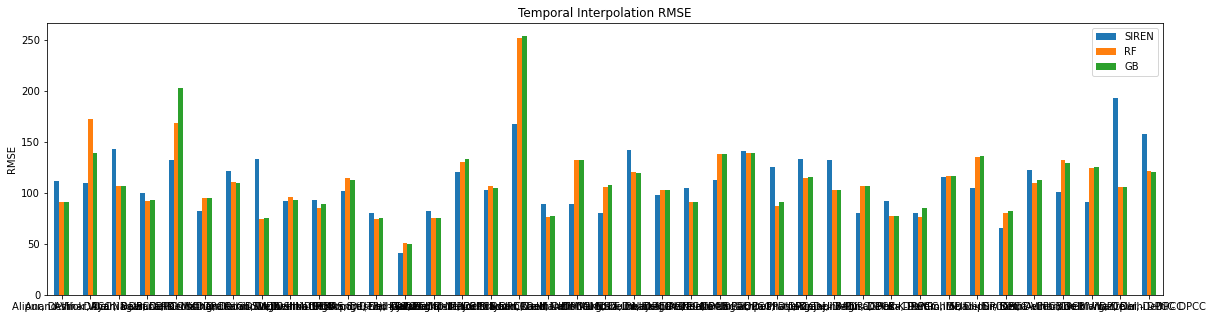

In [26]:
result_df = pd.DataFrame(index=all_stations)
models = ["SIREN", "RF", "GB"]
for model in models:
    df = pd.read_csv(f"results/temporal_interpolation_{model}.csv").set_index("station")
    result_df[model] = df["rmse"]

# plot the results as bar chart
result_df.plot.bar(figsize=(20, 5), rot=0, title="Temporal Interpolation RMSE", ylabel="RMSE");